In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
example = "Quadratic"

In [3]:
#############################################################################
# Solve the system
#############################################################################

def solve(M,f):
    return np.linalg.solve(M,f)

In [35]:
#############################################################################
# Loading
#############################################################################

def f(x):
    
    if example == "Cubic":
        return -( 2/np.sqrt(3)) * ( -6 + 4*x )
    elif example == "Quartic":
        return  -32/9 + 64/9 * x - 64/27 * x * x
    elif example == "Quadratic":
        return 8/9
    else:
        print("Error: Either provide Quadratic, Quartic, or Cubic")
        sys.exit()

def forceFull(n,h):
    
    force = np.zeros(n)
   
    for i in range(1,n-1):
        force[i] = f(i * h)
    
    force[n-1] = 0
    
    return force

def forceCoupling(n,x):
    
    dim = 2*n + 2*n-1
    
    force = np.zeros(dim)
   
    for i in range(1,dim-1):
        force[i] = f(x[i])
    
    force[dim-1] = 0
    
    return force

In [76]:
#############################################################################
# Assemble the stiffness matrix for the coupling of FDM - VHM - FDM
#############################################################################

def CouplingFDVHM(n,h):

    fVHM = 1./(8.*h*h)
    fFDM = 1./(2.*h/2*h/2)
    
    dim = 2*n + 2*n-1
    

    M = np.zeros([dim,dim])
    
    M[0][0] = 1 * fFDM

    for i in range(1,n-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[n-1][n-1] = -1 
    M[n-1][n] = 1  

    M[n][n-1] = 11*h * fFDM / 3
    M[n][n-2] = -18*h * fFDM / 3
    M[n][n-3] = 9*h * fFDM / 3
    M[n][n-4] = -2*h * fFDM / 3

    M[n][n] = 11 / 6 / h 
    M[n][n+1] = -18 / 6 / h
    M[n][n+2] = 9 / 6 / h
    M[n][n+3] = -2 / 6 / h

    M[n+1][n] = -8 * fVHM
    M[n+1][n+1] = 16 * fVHM
    M[n+1][n+2] = -8 * fVHM
    
    mid = n+2*n -2

    for i in range(n+2,mid):
        M[i][i-2] = -1. * fVHM
        M[i][i-1] = -4. * fVHM
        M[i][i] = 10. * fVHM
        M[i][i+1] =  -4. * fVHM
        M[i][i+2] = -1. * fVHM
        
   
        
    M[mid][mid-1] = -8 * fVHM
    M[mid][mid] = 16 * fVHM
    M[mid][mid+1] = -8 * fVHM

    M[mid+1][mid-1] = -1 
    M[mid+1][mid] = 1  

    M[mid+2][mid+2-1] = 11 / 6 / h
    M[mid+2][mid+2-2] = -18 / 6 / h
    M[mid+2][mid+2-3] = 9 / 6 / h
    M[mid+2][mid+2-4] = -2 / 6 / h

    M[mid+2][mid+2] = 11*h * fFDM / 3
    M[mid+2][mid+2+1] = -18*h * fFDM / 3
    M[mid+2][mid+2+2] = 9*h * fFDM / 3
    M[mid+2][mid+2+3] = -2*h * fFDM / 3

    for i in range(mid+3,dim-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    M[dim-1][dim-1] = 1

    #print(M)
    return M

In [83]:
def compute(i):
    
    n = np.power(2,int(i))
    h = 1./n
    nodes = n + 1
    
    print(nodes,h)
    x1 = np.linspace(0,1,nodes)
    x2 = np.linspace(1,2.,2*nodes-1)
    x3 = np.linspace(2,3.,nodes)
    x = np.array(np.concatenate((x1,x2,x3)))
    #print(len(x2))
    
    M = CouplingFDVHM(nodes,h)
    
    f = forceCoupling(nodes,x)
    
    f[n] = 0
    f[n+1] = 0
    
    mid = n+2*n+1

    f[mid] = 0
    f[mid+1] = 0
    
    #print(f)
    
    u = solve(M,f)
    

    
    x1 = x[0:nodes]
    x2 = x[nodes+1:mid+2]
    x3 = x[mid+2:len(x)]
    
    u1 = u[0:nodes]
    u2 = u[nodes+1:mid+2]
    u3 = u[mid+2:len(x)]
    
    x = np.concatenate([x1,x2,x3])
    u = np.concatenate([u1,u2,u3])
    
    plt.plot(x,u)
    plt.grid(True)

5 0.25


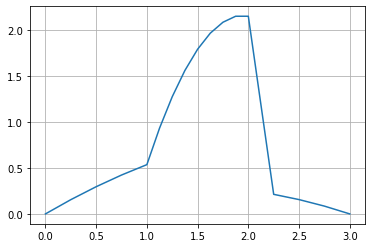

In [84]:
compute(2)